---------
# Recovering secret in SSTIC challenge SCA 
-------
<img src='images/DoIt.png' style='width: 100px'>

# DO IT YOURSELF

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np

<img src='images/DoIt.png' style='width: 100px'>

#### Load the trace 'RSA_SSTIC_power_consumption.npz'
from SideSCA-Traces-Public: git clone https://github.com/BeneoLix/SideSCA-Traces-Public.git

In [3]:
trace_npz = ...
trace_lst = trace_npz.files

In [7]:
print(trace_lst)

['arr_0']


In [8]:
trace = trace_npz['arr_0']
len(trace)

1842128

In [9]:
trace[0:20]

array([ 0.00387928,  0.05724333, -0.01318807, -0.02729493, -0.02348536,
        0.0465676 ,  0.04035217, -0.01577941, -0.02894039,  0.01174628,
        0.07196697,  0.03027694,  0.00464222,  0.02307723,  0.00593505,
       -0.01687661,  0.05888884, -0.06209962,  0.01097336,  0.01333775])

<img src='images/DoIt.png' style='width: 100px'>

## Plot the trace, zoom, observe and deduce the algorithm here

In [10]:
import matplotlib.pyplot as plt

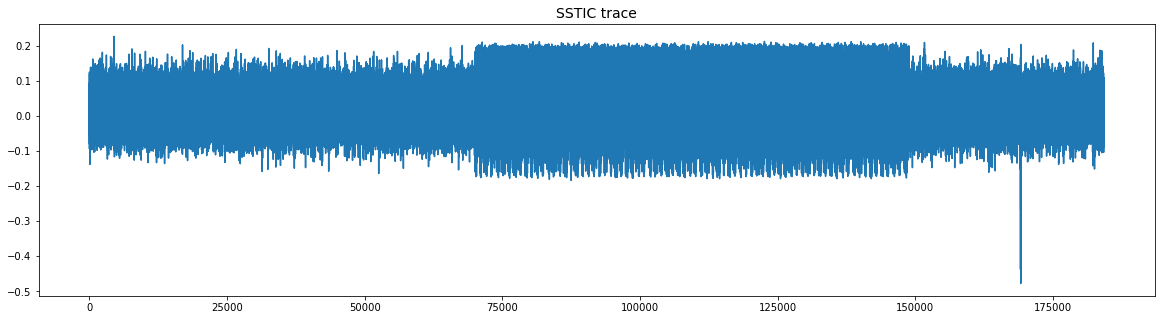

In [11]:
...

#### You can use backend matplotlib

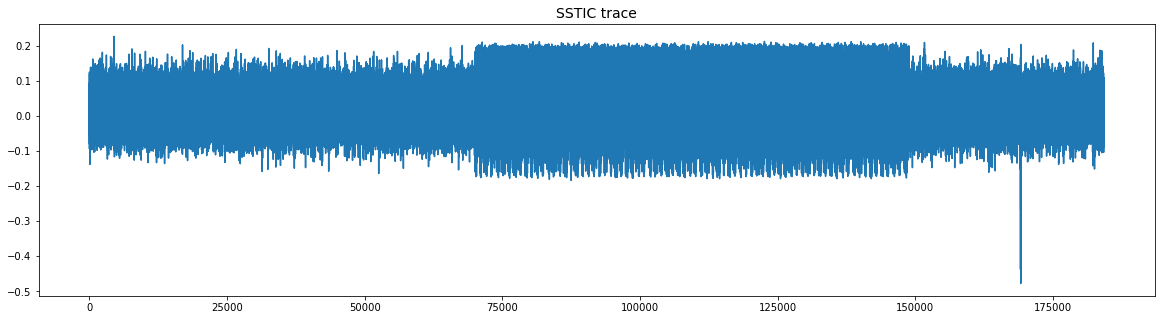

In [12]:
%matplotlib
...

In [13]:
trace_algo = trace[650000:1600000]

In [ ]:
%matplotlib inline
plt.plot(trace_algo[::10])
plt.show()

<img src='images/DoIt.png' style='width: 100px'>

## Can you recover the secret exponent ?

#### Indication:

* modulus N = 0xD072DD3F639C2D0E1FF69AB965782F668D7BFFAC766AEEAB5DA84AE373F8C0DCAA18C6BDCBD551BB012F42AFC0F3FC4AAD438C212FF8A4E597053CD60B54AC484714FBAE059C97F8138CEDE9A80060D3C816288FF2C77D82081E586F73EE78E06F69D7D57596ACF1959D6F3ED00D2CDDB11DECF25A379DEF4DCE3B264AD7E819
* public exponent e = 2**16+1 = 65537

plain = 0x17751699e1fdcf36867e12ce89739596ccc41adaf3cae6c277e37fdd87858d98aa565ca94e8ff15329f3fa05eea43700
f4981b0dc46f33f4df6f0e58f43e5872bad8a82523c4771b6057a961ea318797b9c237f458a48eb8aa80b9019d7e37a72a41abb948
76c5bc4804d6479a35771992dfeffc98f51f61aab9625c7e6fe344

signature = 0x488cc043393414298f7ee857c5067150d3896408fecbadb21f57749b6d7a470e0e57679d304993f0543301142e075
9f84712891d24917568f58e66b8d8a1ee153dcd12df260b1869d3c5a60c9226edd5418aff385719264a6ca38bb916103903901f9b80
a3260c46bed8c26ea42411023d78987668b9ae5d8f9be2137e9db140

## You must have as result:

$$ plain^{recovered\_exponent\_d} = signature$$

You must count 1024 operations/peaks, so not 1024+512 as we would expect from a classical Square&Multiply algorithm.

So let's suppose:
- the higher peaks are squaring+multiplication
- the lower peaks are only squaring